# Compare meteorological SPEI calculation with different PET equations

## Introduction
In the following notebook the meteorological calculation of the `n`-month SPEI with different PET equations is compared to the offical [Global SPEI database](https://spei.csic.es/database.html). The PET equations "FAO 56 Penman-Monteith", "Thornthwaite", "Priestley-Taylor" and "Hargreaves" were used for the calculation.

As input data `ASCII` files are used which represent the `n`-month SPEI in Germany. To calculate the meteorological SPEI from the [DWD](https://opendata.dwd.de/climate_environment/CDC/) (*Deutscher Wetterdienst*) is used (*see [spei_meteorological.ipynb](../methods/meteorological/spei_meteorological.ipynb) for more details*).

The "log-logistic" distribution has been used for the calculation using all PET equations "FAO 56 Penman-Monteith (FA056PM)", "Thornthwaite (TW)", "Priestley-Taylor (PT)" and "Hargreaves (HG)".

## Implementation

In [2]:
from methods.meteorological.spei_meteorological import read_asc_file
import xarray as xr
import numpy as np
from methods.method1.spei_calc_multi import spatial_subset
from datetime import datetime, timedelta
from config.data_paths import EXT_STORAGE_DIR

Read the `n`-month SPEI `ASCII` files calculated by the equations (*FAO-56-PM, TW, PT, HG*).

The variable `n` can be adjusted to `1`, `3`, `6`, `9` or `12` to read the corresponding SPEI files which are located in `methods/meteorological/output`.

In [3]:
n = 1
spei_asc = {}

begin_date = datetime(2022,1,1)
end_date = datetime(2022,11,1)
curr_date = begin_date
equations = ["fao56pm", "tw", "pt", "hg"]
for equation in equations:
    while curr_date <= end_date:
        curr_date_str = curr_date.strftime("%Y%m")
        spei_np, header = read_asc_file(f"../methods/meteorological/output/{n}month/spei_{equation}_ll_{curr_date_str}.asc")
        spei_asc[f"{curr_date_str}-{equation}"] = spei_np

        next_month = curr_date.replace(day=28) + timedelta(days=4)
        curr_date = next_month - timedelta(days=next_month.day - 1)
    curr_date = begin_date


Set the latitude and longitude bounds for the region of Germany and read the official SPEI database's netCDF file
and extract the SPEI values for the region of Germany.

The `.nc` files represents the SPEI values of the whole world from 16th January 1901 to 16th December 2022. The files have been generated by the inventors of the SPEI calculation method.

At [Global SPEI database](https://spei.csic.es/database.html) the `.nc` file can be downloaded.

In [4]:
# Lat and lon bounds for Germany
lat_bounds = [47.0, 55.0]
lon_bounds = [5.5, 15.0]

# Open netCDF file
spei_db = xr.open_dataset(f"{EXT_STORAGE_DIR}/drought_data/spei/spei_db/spei_v2-9_19010116_20221216.nc")
spei_db_ger = spatial_subset(spei_db, lat_bounds, lon_bounds)
spei_db_ger

<xarray.Dataset> Size: 2MB
Dimensions:  (lon: 19, lat: 16, time: 1464)
Coordinates:
  * lon      (lon) float64 152B 5.75 6.25 6.75 7.25 ... 13.25 13.75 14.25 14.75
  * lat      (lat) float64 128B 47.25 47.75 48.25 48.75 ... 53.75 54.25 54.75
  * time     (time) datetime64[ns] 12kB 1901-01-16 1901-02-15 ... 2022-12-16
Data variables:
    spei     (time, lat, lon) float32 2MB ...
    crs      int32 4B ...
Attributes: (12/15)
    Conventions:  CF-1.8
    title:        Global 1-month SPEI, z-values, 0.5 degree
    version:      2.9
    id:           ../outputNcdf/spei01.nc
    summary:      Global dataset of the Standardized Precipitation-Evapotrans...
    keywords:     drought, climatology, SPEI, Standardized Precipitation-Evap...
    ...           ...
    software:     Created in R using the SPEI package (https://cran.r-project...
    call:         spei.nc(sca=i, inPre=../inputData/cru_ts4.07.1901.2022.pre....
    date:         Wed Jun 21 14:20:48 2023
    reference:    Beguería S., Vicente-Serrano S., Reig F., Latorre B. (2014)...
    reference2:   Vicente-Serrano S.M., Beguería S., López-Moreno J.I. (2010)...
    reference3:   Beguería S., Vicente-Serrano S., Angulo-Martínez M. (2010) ...

Load a shape file of Germany to plot the SPEI values to the region of Germany.

In [5]:
import rioxarray
import geopandas as gpd
from shapely.geometry import mapping

shape_ger = f"{EXT_STORAGE_DIR}/shape_ger/vg2500_sta.shp"
germany = gpd.read_file(shape_ger)
germany = germany.to_crs('EPSG:4326')

xds = spei_db_ger.rio.write_crs("EPSG:4326")
spei_db_ger_shape = xds.rio.clip(germany.geometry.apply(mapping), germany.crs, drop=True, invert=False)

In [6]:
for var in spei_db_ger_shape.variables:
    if 'grid_mapping' in spei_db_ger_shape[var].attrs:
        del spei_db_ger_shape[var].attrs['grid_mapping']

In [7]:
spei_db_ger_shape["spei"]

<xarray.DataArray 'spei' (time: 1464, lat: 15, lon: 18)> Size: 2MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.18558681,
                 nan,         nan],
        ...,
        [        nan,         nan, -0.2857917 , ..., -0.20788448,
         -0.15176886,         nan],
        [        nan,         nan,         nan, ..., -0.24521767,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.31229413,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.04803436,
                 nan,         nan],
...
        [        nan,         nan, -0.58256215, ..., -1.9322487 ,
         -1.9431359 ,         nan],
        [        nan,         nan,         nan, ..., -2.0667753 ,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -2.086224  ,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,  0.19749083,
                 nan,         nan],
        ...,
        [        nan,         nan,  0.4825068 , ...,  0.1127845 ,
          0.08029249,         nan],
        [        nan,         nan,         nan, ...,  0.09399618,
                 nan,         nan],
        [        nan,         nan,         nan, ...,  0.07449882,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 144B 6.25 6.75 7.25 7.75 ... 13.25 13.75 14.25 14.75
  * lat      (lat) float64 120B 47.75 48.25 48.75 49.25 ... 53.75 54.25 54.75
  * time     (time) datetime64[ns] 12kB 1901-01-16 1901-02-15 ... 2022-12-16
    crs      int64 8B 0
Attributes:
    units:      1
    long_name:  Standardized Precipitation-Evapotranspiration Index

Extract the min, max and mean values for each month and PET equation's dataset.

In [8]:
spei_data = {
    "Month": [],
    "Min SPEI - FAO56PM": [],
    "Min SPEI - TW": [],
    "Min SPEI - PT": [],
    "Min SPEI - HG": [],
    "Min SPEI - SPEI_DB": [],
    "Max SPEI - FAO56PM": [],
    "Max SPEI - TW": [],
    "Max SPEI - PT": [],
    "Max SPEI - HG": [],
    "Max SPEI - SPEI_DB": [],
    "Mean SPEI - FAO56PM": [],
    "Mean SPEI - TW": [],
    "Mean SPEI - PT": [],
    "Mean SPEI - HG": [],
    "Mean SPEI - SPEI_DB": [],
}

In [9]:
curr_date = begin_date
for equation in equations:
    while curr_date <= end_date:
        curr_date_str = curr_date.strftime("%Y%m")
        
        if not curr_date.strftime("%Y-%m") in spei_data["Month"]:
            spei_data["Month"].append(curr_date.strftime("%Y-%m"))
        spei_asc_equation = spei_asc[f"{curr_date_str}-{equation}"]
        spei_data[f"Min SPEI - {equation.upper()}"].append(np.nanmin(spei_asc_equation))
        spei_data[f"Max SPEI - {equation.upper()}"].append(np.nanmax(spei_asc_equation))
        spei_data[f"Mean SPEI - {equation.upper()}"].append(np.nanmean(spei_asc_equation))

        next_month = curr_date.replace(day=28) + timedelta(days=4)
        curr_date = next_month - timedelta(days=next_month.day - 1)
    curr_date = begin_date

In [10]:
while curr_date <= end_date:
    print(curr_date)
    curr_date_str = curr_date.strftime("%Y%m")

    spei_netcdf_np = spei_db_ger_shape["spei"].sel(time=slice(f"{curr_date.strftime('%Y-%m')}-01", f"{curr_date.strftime('%Y-%m')}-28"))
    spei_data["Min SPEI - SPEI_DB"].append(np.nanmin(spei_netcdf_np.values))
    spei_data["Max SPEI - SPEI_DB"].append(np.nanmax(spei_netcdf_np.values))
    spei_data["Mean SPEI - SPEI_DB"].append(np.nanmean(spei_netcdf_np.values))

    next_month = curr_date.replace(day=28) + timedelta(days=4)
    curr_date = next_month - timedelta(days=next_month.day - 1)

2022-01-01 00:00:00
2022-02-01 00:00:00
2022-03-01 00:00:00
2022-04-01 00:00:00
2022-05-01 00:00:00
2022-06-01 00:00:00
2022-07-01 00:00:00
2022-08-01 00:00:00
2022-09-01 00:00:00
2022-10-01 00:00:00
2022-11-01 00:00:00


In [11]:
spei_data

{'Month': ['2022-01',
  '2022-02',
  '2022-03',
  '2022-04',
  '2022-05',
  '2022-06',
  '2022-07',
  '2022-08',
  '2022-09',
  '2022-10',
  '2022-11'],
 'Min SPEI - FAO56PM': [-3.8007,
  -2.4907,
  -2.3791,
  -2.896,
  -3.6741,
  -2.2118,
  -2.608,
  -2.4262,
  -2.9697,
  -2.338,
  -2.3037],
 'Min SPEI - TW': [-4.4906,
  -10.1343,
  -7.6537,
  -14.8085,
  -3.6177,
  -2.3685,
  -2.5422,
  -2.1596,
  -3.0961,
  -2.4824,
  -20.5816],
 'Min SPEI - PT': [-2.7523,
  -2.3044,
  -2.5518,
  -3.9518,
  -3.1648,
  -2.6915,
  -2.1881,
  -3.438,
  -3.246,
  -2.8586,
  -3.2408],
 'Min SPEI - HG': [-3.6538,
  -2.6386,
  -1.6496,
  -3.1768,
  -3.3776,
  -2.3734,
  -2.6035,
  -1.9329,
  -3.0924,
  -2.4806,
  -2.3933],
 'Min SPEI - SPEI_DB': [-1.3099864,
  -0.79512864,
  -2.8354368,
  -0.89830106,
  -1.9662479,
  -2.4811935,
  -2.1054492,
  -2.316696,
  -0.122050665,
  -1.5321984,
  -2.090944],
 'Max SPEI - FAO56PM': [3.921,
  7.2692,
  3.2264,
  3.9096,
  5.3479,
  4.8418,
  4.0289,
  4.0261,
  4.2569

Create the minimum monthly `n`-month SPEI values for each PET equation and compare them to the official SPEI values.

In [12]:
import pandas as pd

spei_df = pd.DataFrame(spei_data)
spei_df['Month'] = pd.to_datetime(spei_df['Month'])

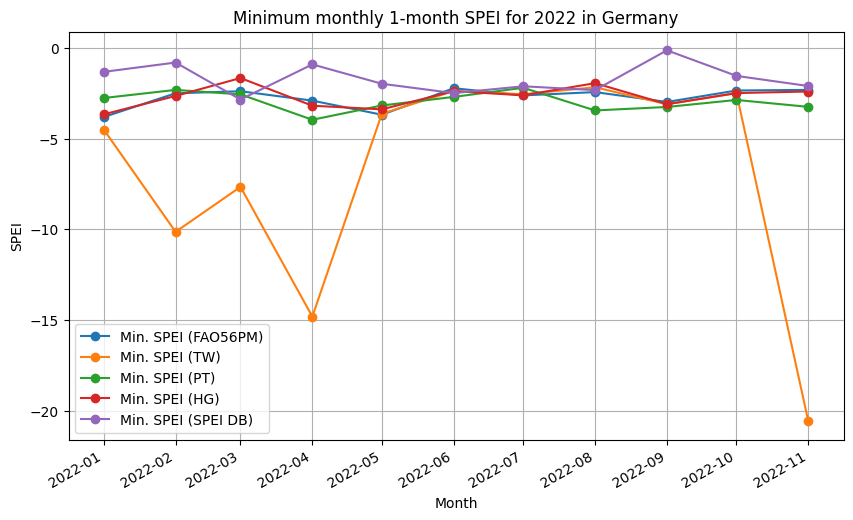

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set the plot size
plt.figure(figsize=(10, 6))

# Plot each temperature metric
for equation in equations:
    plt.plot(spei_df['Month'], spei_df[f'Min SPEI - {equation.upper()}'], label=f'Min. SPEI ({equation.upper()})', marker='o')

plt.plot(spei_df['Month'], spei_df[f'Min SPEI - SPEI_DB'], label=f'Min. SPEI (SPEI DB)', marker='o')

# Formatting the plot
plt.title('Minimum monthly 1-month SPEI for 2022 in Germany')
plt.xlabel('Month')
plt.ylabel('SPEI')
plt.legend()
plt.grid(True)

# Improve the x-axis to show each month more clearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Rotate date labels to prevent overlap

plt.show()

Create the maximum monthly `n`-month SPEI values for each PET equation and compare them to the official SPEI values.

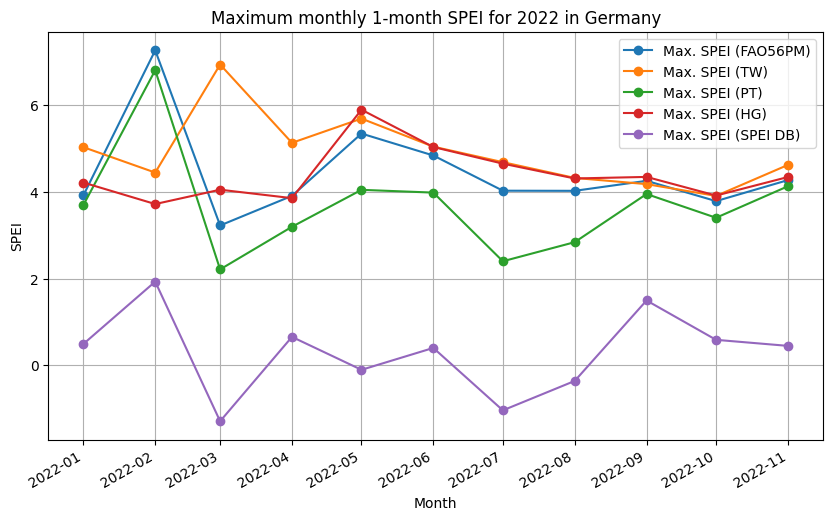

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set the plot size
plt.figure(figsize=(10, 6))

# Plot each temperature metric
for equation in equations:
    plt.plot(spei_df['Month'], spei_df[f'Max SPEI - {equation.upper()}'], label=f'Max. SPEI ({equation.upper()})', marker='o')

plt.plot(spei_df['Month'], spei_df[f'Max SPEI - SPEI_DB'], label=f'Max. SPEI (SPEI DB)', marker='o')

# Formatting the plot
plt.title('Maximum monthly 1-month SPEI for 2022 in Germany')
plt.xlabel('Month')
plt.ylabel('SPEI')
plt.legend()
plt.grid(True)

# Improve the x-axis to show each month more clearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Rotate date labels to prevent overlap

plt.show()


Create the mean monthly `n`-month SPEI values for each PET equation and compare them to the official SPEI values.

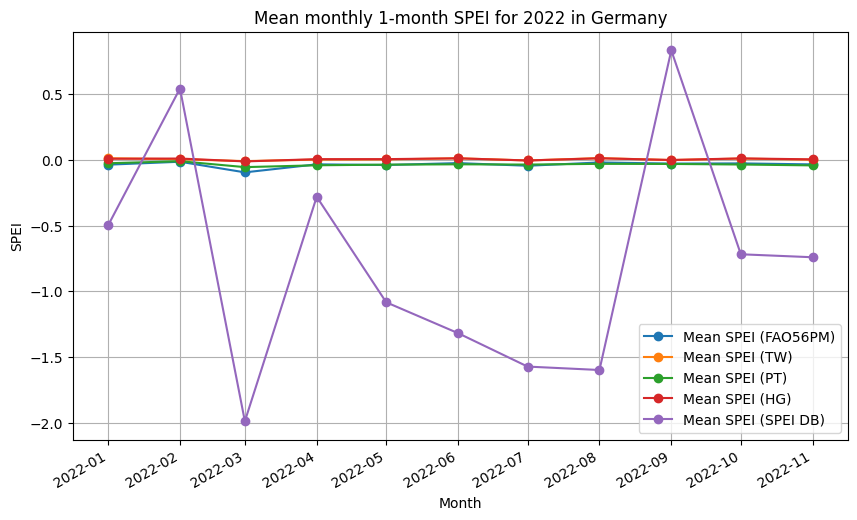

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set the plot size
plt.figure(figsize=(10, 6))

# Plot each temperature metric
for equation in equations:
    plt.plot(spei_df['Month'], spei_df[f'Mean SPEI - {equation.upper()}'], label=f'Mean SPEI ({equation.upper()})', marker='o')

plt.plot(spei_df['Month'], spei_df[f'Mean SPEI - SPEI_DB'], label=f'Mean SPEI (SPEI DB)', marker='o')

# Formatting the plot
plt.title('Mean monthly 1-month SPEI for 2022 in Germany')
plt.xlabel('Month')
plt.ylabel('SPEI')
plt.legend()
plt.grid(True)

# Improve the x-axis to show each month more clearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Rotate date labels to prevent overlap

plt.show()


In [16]:
spei_df

,Month,Min SPEI - FAO56PM,Min SPEI - TW,Min SPEI - PT,Min SPEI - HG,Min SPEI - SPEI_DB,Max SPEI - FAO56PM,Max SPEI - TW,Max SPEI - PT,Max SPEI - HG,Max SPEI - SPEI_DB,Mean SPEI - FAO56PM,Mean SPEI - TW,Mean SPEI - PT,Mean SPEI - HG,Mean SPEI - SPEI_DB
0,2022-01-01,-3.8007,-4.4906,-2.7523,-3.6538,-1.309986,3.9210,5.0335,3.6967,4.2167,0.490700,-0.035477,0.013585,-0.024698,0.009594,-0.497564
1,2022-02-01,-2.4907,-10.1343,-2.3044,-2.6386,-0.795129,7.2692,4.4472,6.8099,3.7207,1.930228,-0.013152,0.005991,-0.009086,0.011303,0.544446
2,2022-03-01,-2.3791,-7.6537,-2.5518,-1.6496,-2.835437,3.2264,6.9415,2.2123,4.0519,-1.292753,-0.094012,-0.008464,-0.054108,-0.010637,-1.988921
3,2022-04-01,-2.8960,-14.8085,-3.9518,-3.1768,-0.898301,3.9096,5.1339,3.1959,3.8570,0.654359,-0.032910,0.003167,-0.040095,0.006605,-0.279821
4,2022-05-01,-3.6741,-3.6177,-3.1648,-3.3776,-1.966248,5.3479,5.6934,4.0489,5.8988,-0.105669,-0.037860,0.004304,-0.035227,0.006737,-1.083340
5,2022-06-01,-2.2118,-2.3685,-2.6915,-2.3734,-2.481194,4.8418,5.0456,3.9850,5.0371,0.399428,-0.023410,0.013150,-0.032701,0.012940,-1.318367
6,2022-07-01,-2.6080,-2.5422,-2.1881,-2.6035,-2.105449,4.0289,4.6876,2.4002,4.6534,-1.041424,-0.043679,-0.003476,-0.034623,-0.003430,-1.572776
7,2022-08-01,-2.4262,-2.1596,-3.4380,-1.9329,-2.316696,4.0261,4.3237,2.8408,4.3112,-0.362587,-0.018687,0.014494,-0.029150,0.013293,-1.598771
8,2022-09-01,-2.9697,-3.0961,-3.2460,-3.0924,-0.122051,4.2569,4.1808,3.9522,4.3472,1.495043,-0.027074,-0.000294,-0.029911,0.000184,0.835164
9,2022-10-01,-2.3380,-2.4824,-2.8586,-2.4806,-1.532198,3.7888,3.9089,3.4042,3.9167,0.586420,-0.025714,0.011173,-0.034260,0.012350,-0.717664


## Percentages
Shows the percentage of the calculated SPEI values that are:
- above the value `+1.0` (*wet*)
- between or equal the value `-1.0` and `+1.0` (*normal*)
- below the value `-1.0` (*dry*)
  

In [17]:
equations.append("SPEI_DB")

In [18]:
curr_date = begin_date
perc_results = {}
perc_results_sum = {}
for equation in equations:
    iterations = 0
    while curr_date <= end_date:
        if equation.upper() == "SPEI_DB":
            values = spei_db_ger_shape["spei"].sel(time=slice(
                f"{curr_date.strftime('%Y-%m')}-01", f"{curr_date.strftime('%Y-%m')}-28")).values
        else:
            values = spei_asc[f"{curr_date_str}-{equation.lower()}"]

        curr_date_str = curr_date.strftime("%Y%m")

        # if not curr_date.strftime("%Y-%m") in spei_data["Month"]:
        #     spei_data["Month"].append(curr_date.strftime("%Y-%m"))

        # perc_over_plus1 = (values > 1.0).mean() * 100
        # perc_below_minus1 = (values < -1.0).mean() * 100
        # perc_ok = (spei_df[f'Min SPEI - {equation.upper()}'].between(-1.0, 1.0)).mean() * 100

        values_size = values.size
        ed = values[(values <= -2.0)].size / values_size * 100
        sd = values[(-2.0 < values) & (values <= -1.5)].size / values_size * 100
        md = values[(-1.5 < values) & (values <= -1.0)
                    ].size / values_size * 100
        n = values[(-1.0 < values) & (values < 1.0)].size / values_size * 100
        mw = values[(1.0 <= values) & (values < 1.5)].size / values_size * 100
        sw = values[(1.5 <= values) & (values < 2.0)].size / values_size * 100
        ew = values[(2.0 <= values)].size / values_size * 100

        # sd = values[(-2.0 < values) & (values <= -1.5)].mean() #* 100
        # md = values[(-1.5 < values) & (values <= -1.0)].mean() #* 100
        # n = values[(-1.0 < values) & (values < 1.0)].mean() #* 100
        # mw = values[(1.0 <= values) & (values < 1.5)].mean() #* 100
        # sw = values[(1.5 <= values) & (values < 2.0)].mean() #* 100
        # ew = values[(2.0 <= values)].mean() #* 100

        if not curr_date_str in perc_results:
            perc_results[curr_date_str] = {}

        perc_results[curr_date_str][equation.upper()] = {
            "ed": ed,
            "sd": sd,
            "md": md,
            "n": n,
            "mw": mw,
            "sw": sw,
            "ew": ew,
        }

        if not equation.upper() in perc_results_sum:
            perc_results_sum[equation.upper()] = {}

        if (not "ed" in perc_results_sum[equation.upper()]):
            perc_results_sum[equation.upper()] = {
                "ed": ed,
                "sd": sd,
                "md": md,
                "n": n,
                "mw": mw,
                "sw": sw,
                "ew": ew,
            }
        else:
            perc_results_sum[equation.upper()]["ed"] += ed
            perc_results_sum[equation.upper()]["sd"] += sd
            perc_results_sum[equation.upper()]["md"] += md
            perc_results_sum[equation.upper()]["n"] += n
            perc_results_sum[equation.upper()]["mw"] += mw
            perc_results_sum[equation.upper()]["sw"] += sw
            perc_results_sum[equation.upper()]["ew"] += ew

        next_month = curr_date.replace(day=28) + timedelta(days=4)
        curr_date = next_month - timedelta(days=next_month.day - 1)
        iterations += 1
    curr_date = begin_date

In [19]:
from dateutil.relativedelta import relativedelta

difference = relativedelta(end_date, begin_date)
total_months = difference.years * 12 + difference.months
print(total_months)
for equation in equations:
    perc_results_sum[equation.upper()]["ed"] = perc_results_sum[equation.upper()]["ed"] / total_months
    perc_results_sum[equation.upper()]["sd"] = perc_results_sum[equation.upper()]["sd"] / total_months
    perc_results_sum[equation.upper()]["md"] = perc_results_sum[equation.upper()]["md"] / total_months
    perc_results_sum[equation.upper()]["n"] = perc_results_sum[equation.upper()]["n"] / total_months
    perc_results_sum[equation.upper()]["mw"] = perc_results_sum[equation.upper()]["mw"] / total_months
    perc_results_sum[equation.upper()]["sw"] = perc_results_sum[equation.upper()]["sw"] / total_months
    perc_results_sum[equation.upper()]["ew"] = perc_results_sum[equation.upper()]["ew"] / total_months

10


In [20]:
perc_results_sum

{'FAO56PM': {'ed': 0.5921810002048152,
  'sd': 2.9808744906102786,
  'md': 8.363649525746691,
  'n': 47.53155214667599,
  'mw': 6.03110367184355,
  'sw': 2.6055328375391094,
  'ew': 1.3369846953549307},
 'TW': {'ed': 0.684259592770727,
  'sd': 3.1756079129323194,
  'md': 8.33412787535931,
  'n': 46.16591096891752,
  'mw': 6.178800206227797,
  'sw': 3.0331553559195146,
  'ew': 2.018242684916414},
 'PT': {'ed': 1.5530295004626,
  'sd': 3.5845145524786184,
  'md': 5.971089264148145,
  'n': 49.04365390455607,
  'mw': 6.472533564986475,
  'sw': 2.1917706633896223,
  'ew': 0.6361456589754998},
 'HG': {'ed': 0.5281938823795297,
  'sd': 3.4817714402751583,
  'md': 8.495649440995544,
  'n': 45.22718604996079,
  'mw': 6.404397172136646,
  'sw': 3.302452133257057,
  'ew': 2.1504544780388586},
 'SPEI_DB': {'ed': 7.259259259259258,
  'sd': 14.333333333333334,
  'md': 16.259259259259256,
  'n': 38.03703703703704,
  'mw': 4.333333333333333,
  'sw': 0.8518518518518519,
  'ew': 0.0}}

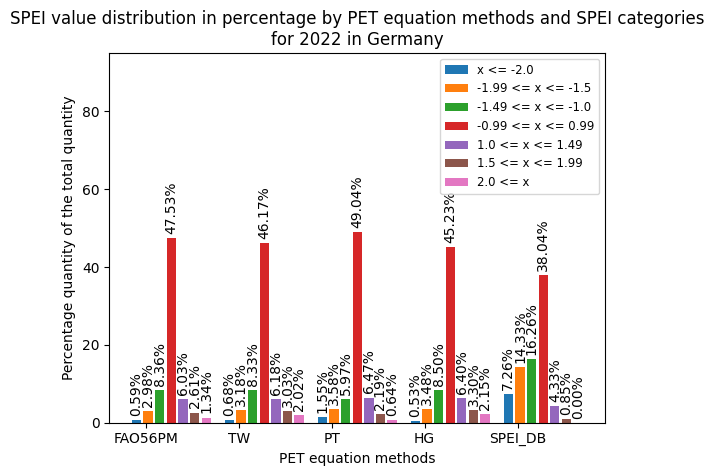

In [21]:
import matplotlib.pyplot as plt

equations = list(perc_results_sum.keys())
ed = [perc_results_sum[method]['ed'] for method in equations]
sd = [perc_results_sum[method]['sd'] for method in equations]
md = [perc_results_sum[method]['md'] for method in equations]
n = [perc_results_sum[method]['n'] for method in equations]
mw = [perc_results_sum[method]['mw'] for method in equations]
sw = [perc_results_sum[method]['sw'] for method in equations]
ew = [perc_results_sum[method]['ew'] for method in equations]

x = range(len(equations))
bar_width = 0.1

r1 = range(len(equations))
bar_gap=1.25
r2 = [x + bar_gap*bar_width for x in r1]
r3 = [x + bar_gap*bar_width for x in r2]
r4 = [x + bar_gap*bar_width for x in r3]
r5 = [x + bar_gap*bar_width for x in r4]
r6 = [x + bar_gap*bar_width for x in r5]
r7 = [x + bar_gap*bar_width for x in r6]

fig, ax = plt.subplots()
rects1 = ax.bar(r1, ed, bar_width, label='x <= -2.0')
rects2 = ax.bar(r2, sd, bar_width, label='-1.99 <= x <= -1.5')
rects3 = ax.bar(r3, md, bar_width, label='-1.49 <= x <= -1.0')
rects4 = ax.bar(r4, n, bar_width, label='-0.99 <= x <= 0.99')
rects5 = ax.bar(r5, mw, bar_width, label='1.0 <= x <= 1.49')
rects6 = ax.bar(r6, sw, bar_width, label='1.5 <= x <= 1.99')
rects7 = ax.bar(r7, ew, bar_width, label='2.0 <= x')

for rect in rects1 + rects2 + rects3 + rects4 + rects5 + rects6 + rects7:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}%', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", rotation='vertical',
                ha='center', va='bottom')

plt.ylim(0, 95)
ax.set_xlabel('PET equation methods')
ax.set_ylabel('Percentage quantity of the total quantity')
ax.set_title('SPEI value distribution in percentage by PET equation methods and SPEI categories\nfor 2022 in Germany')
ax.set_xticks([i + bar_width for i in x])
ax.set_xticklabels(equations)
ax.legend(fontsize='small')

plt.show()

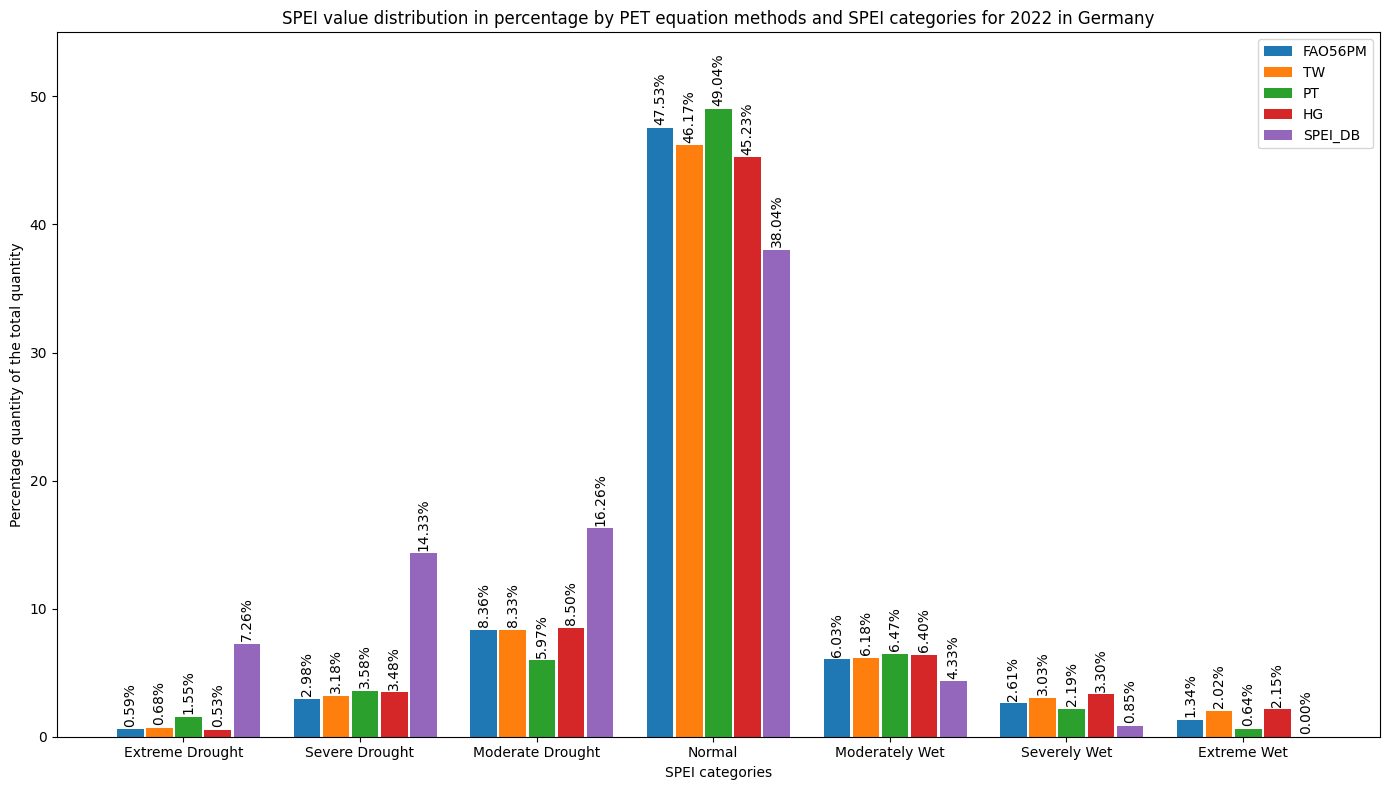

In [22]:
import matplotlib.pyplot as plt
import numpy as np

equations = ['FAO56PM', 'TW', 'PT', 'HG', 'SPEI_DB']
spei_categories = ['ed', 'sd', 'md', 'n', 'mw', 'sw', 'ew']
spei_category_names = ['Extreme Drought', 'Severe Drought', 'Moderate Drought', 'Normal',
                   'Moderately Wet', 'Severely Wet', 'Extreme Wet']

x = np.arange(len(spei_categories)) * 0.05  # the label locations with larger gaps

width = 0.0075  # width of the bars

fig, ax = plt.subplots(figsize=(14, 8))

for i, equation in enumerate(equations):
    values = [perc_results_sum[equation][metric] for metric in spei_categories]
    bars = ax.bar(x + i*width *1.1, values, width, label=equation)

    # Bar text annotations
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.2,
                f'{yval:.2f}%', ha='center', va='bottom', rotation='vertical')

# Labels, title and custom x-axis tick labels, etc.
ax.set_ylim(0, 55)
ax.set_xlabel('SPEI categories')
ax.set_ylabel('Percentage quantity of the total quantity')
ax.set_title(
    'SPEI value distribution in percentage by PET equation methods and SPEI categories for 2022 in Germany')
# Adjusted the xticks for centered labels
ax.set_xticks(x + width * (len(equations) / 2 - 0.5))
ax.set_xticklabels(spei_category_names)
ax.legend()

fig.tight_layout()

plt.show()

The results demonstrate that the Normal category is the most represented across all methods, with percentages ranging from 38.04% for SPEI_DB to 49.04% for PT. The SPEI_DB method reveals a higher tendency for drought conditions, particularly in the Severe Drought and Moderate Drought categories, with percentages of 14.33% and 16.26%. This contrasts with the other methods, which report lower values in these categories. For instance, the FAO56PM method shows 2.98% for Severe Drought and 8.36% for Moderate Drought.

In the context of extreme wet conditions, all methods report minimal percentages, with the SPEI_DB showing no occurrence of Extreme Wet conditions (0.00%). The differences among the PET methods highlight the sensitivity of SPEI calculations to the choice of PET equation, which can significantly affect the assessment of drought and wet conditions.

Here is the SPEI categories table for a better understanding:

| SPEI value | Condition     |
|------------|---------------|
| x <= -2.0 | Extreme drought      |
| -1.99 <= x <= -1.50  | Severe drought |
| -1.49 <= x <= -1.0  | Moderate drought |
| -0.99 <= x < 0.99   | Normal       |
| 1.0 <= x <= 1.49    | Moderately Wet          |
| 1.50 <= x <= 1.99    | Severely wet      |
| 2.0 <= x    | Extremely wet |